In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [29]:
# View all of the classes that automap found
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [30]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [34]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [41]:
p_columns=inspector.get_columns('measurement')
for c in p_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [36]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

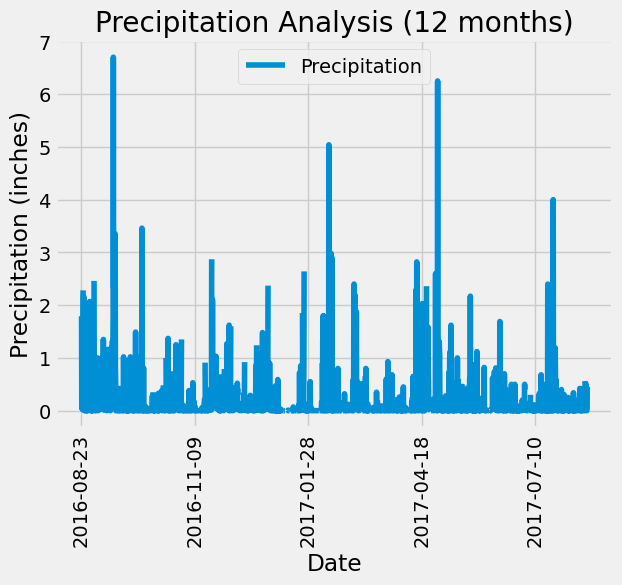

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date

# Calculate the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= ((pd.to_datetime(session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]) - pd.DateOffset(years=1)).strftime("%Y-%m-%d"))).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', legend=True)

plt.title('Precipitation Analysis (12 months)')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation='vertical')

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(precipitation_df['Precipitation'].describe())

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [51]:
s_columns=inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c["type"])

for c in s_columns:
    print(c['name'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id
station
name
latitude
longitude
elevation


In [46]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()


[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_activity = (
    session.query(Measurement.station, func.count())
    .group_by(Measurement.station)
    .order_by(func.count().desc())
    .all()
)
stations_activity[0][0]

'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == stations_activity[0][0]).all()


[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

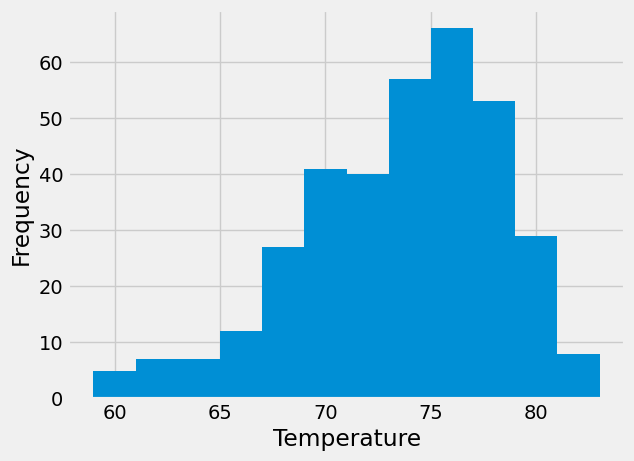

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from sqlalchemy import and_
most_active_temps=session.query(Measurement.tobs).filter(and_(Measurement.station == stations_activity[0][0],Measurement.date >= one_year_ago)).all()
most_active_temps_df=pd.DataFrame(most_active_temps)
plt.hist(most_active_temps_df, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close Session

In [48]:
# Close Session
session.close()